## Run Legacy Models (Perera)

Caleb Phillips (caleb.phillips@nrel.gov) and Dmitry Duplyakin (dmitry.duplyakin@nrel.gov)

The purpose of this notebook is to run the Legacy "LOM"s which form a baseline for more complex models. These include:

 - Vanilla Perera: The original Perera with infinite length obstacles
 - Perera 2: A version of Perera proposed in the WaSP paper with finite length obstacles
 - Perera 3: A version of Perera proposed in the WaSP paper with asymmetric finite length obstacles
 
In practice, all three models are quite similar.

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
from dw_tap.lom import run_lom
import os
import seaborn as sns
import glob
from dw_tap.data_processing import _LatLon_To_XY, filter_obstacles

from pyproj import Transformer
from shapely.geometry import LineString, Polygon, MultiPolygon, Point, MultiPoint, shape
from shapely.ops import split, nearest_points
import fiona
import perera
import pickle
import common
import site_index

%matplotlib inline
%config InlineBackend.figure_format='retina'

obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"

2023-05-30 08:46:32.936699: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
index = site_index.SiteIndex()

### Select which sites need to be processed and wind data source

In [10]:
# Small test with several sites
selected = index.tids(True)
print(selected)

# One or more of: ["wtk_bc", wtk", "wtk_led_2018", "wtk_led_2019"]
wind_sources = ["wtk","wtk_bc","wtk_led_2018","wtk_led_2019","wtk_led_bc"] 

['t024', 't028', 't034', 't041', 't083', 't114', 't133', 't135', 't139', 't140', 't169', 't170', 't182', 't183', 't192', 't207', 't221']


### Load wind data

In [39]:
atmospheric_inputs = {}

for wind_source in tqdm(wind_sources):

    dfs_by_tid = {}
    
    if wind_source == "wtk":

        wtk_df = pd.read_csv("01 Bergey Turbine Data/wtk.csv.bz2")
        # Create dict with dataframes that correspond to selected tid's
        for tid in selected:
            dfs_by_tid[tid] = wtk_df[wtk_df["tid"] == tid].reset_index(drop=True)
            #display(dfs_by_tid[tid].head(3))

    elif wind_source == "wtk_led_2018":

        wtk_led_2018 = pd.read_csv("01 Bergey Turbine Data/wtk_led_2018.csv.bz2")

        # Create dict with dataframes that correspond to selected tid's
        for tid in selected:
            dfs_by_tid[tid] = wtk_led_2018[wtk_led_2018["tid"] == tid].copy().reset_index(drop=True)
            dfs_by_tid[tid]["datetime"] = dfs_by_tid[tid]["packet_date"]

    elif wind_source == "wtk_led_2019":

        wtk_led_2019 = pd.read_csv("01 Bergey Turbine Data/wtk_led_2019.csv.bz2")

        # Create dict with dataframes that correspond to selected tid's
        for tid in selected:
            dfs_by_tid[tid] = wtk_led_2019[wtk_led_2019["tid"] == tid].copy().reset_index(drop=True)
            dfs_by_tid[tid]["datetime"] = dfs_by_tid[tid]["packet_date"]

    elif wind_source == "wtk_bc":
        wtk_bc_df = pd.read_csv("02 Bias Correction/wtk_bc.csv.bz2")
        
        # Create dict with dataframes that correspond to selected tid's
        for tid in selected:
            dfs_by_tid[tid] = wtk_bc_df[wtk_bc_df["tid"] == tid].reset_index(drop=True)
            
            # Actually use bias corrected wind speeds for further steps (overwrite original ws)
            dfs_by_tid[tid]["ws"] = dfs_by_tid[tid]["ws_bc"]
        
    elif wind_source == "wtk_led_bc":
        wtk_led_bc_df = pd.read_csv("02 Bias Correction/wtk_led_bc.csv.bz2")
        
        # Create dict with dataframes that correspond to selected tid's
        for tid in selected:
            dfs_by_tid[tid] = wtk_led_bc_df[wtk_led_bc_df["tid"] == tid].reset_index(drop=True)
            
            # Actually use bias corrected wind speeds for further steps (overwrite original ws)
            dfs_by_tid[tid]["ws"] = dfs_by_tid[tid]["ws_bc"]
        
    else:
        print("Unsupported wind_source selected:", wind_source)
        continue
        
    atmospheric_inputs[wind_source] = dfs_by_tid

100%|█████████████████████████████████████████████| 5/5 [00:13<00:00,  2.80s/it]


### Load obstacle data

In [26]:
obstacle_inputs = {}
obstacle_inputs_notrees = {}
for tid in selected:
    
    index_row = index.lookup_by_tid(tid)
    z_turbine = index_row["Hub Height (m)"]
    
    obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
    obstacle_data_file = "%s/%sv2.json" % (obstacle_data_dir, tid)
    
    if os.path.exists(obstacle_data_file):
        # Trees case
        obstacle_df = filter_obstacles(tid,gpd.read_file(obstacle_data_file), 
                                       include_trees=True, 
                                       turbine_height_for_checking=z_turbine)
        obstacle_df["tid"] = tid
        obstacle_inputs[tid] = obstacle_df
        
        # No trees case
        obstacle_df = filter_obstacles(tid,gpd.read_file(obstacle_data_file), 
                                       include_trees=False, 
                                       turbine_height_for_checking=z_turbine)
        obstacle_df["tid"] = tid
        obstacle_inputs_notrees[tid] = obstacle_df
    else:
        print("Can't access: %s. Skipping" % obstacle_data_file)

all_obstacle_inputs = pd.concat(obstacle_inputs.values())
all_obstacle_inputs_notrees = pd.concat(obstacle_inputs_notrees.values())

/Users/cphillip/opt/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap/data_processing.py:319: UserWarning: (tid: t034) Detected at least 1 obstacle that is as tall as the studied turbine:
       height feature_type                                           geometry
40  41.015999         tree  POLYGON ((-76.37180 43.52360, -76.37171 43.523...
48  39.621994         tree  POLYGON ((-76.37276 43.52496, -76.37280 43.524...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as the studied turbine:\n%s" % \
/Users/cphillip/opt/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap/data_processing.py:319: UserWarning: (tid: t133) Detected at least 1 obstacle that is as tall as the studied turbine:
       height feature_type                                           geometry
6   55.354065         tree  POLYGON ((-89.40182 39.32820, -89.40186 39.328...
7   47.110229         tree  POLYGON ((-89.40183 39.32799, -89.40184 39.327...
15  52.982788         tree  POLYGON (

In [30]:
dest_file = "%s/all_obstacles_epsg3740.json" % (obstacle_data_dir)
all_obstacle_inputs.to_crs(3740).to_file(dest_file, driver="GeoJSON", index=False)

dest_file = "%s/all_obstacles_notrees_epsg3740.json" % (obstacle_data_dir)
all_obstacle_inputs_notrees.to_crs(3740).to_file(dest_file, driver="GeoJSON", index=False)

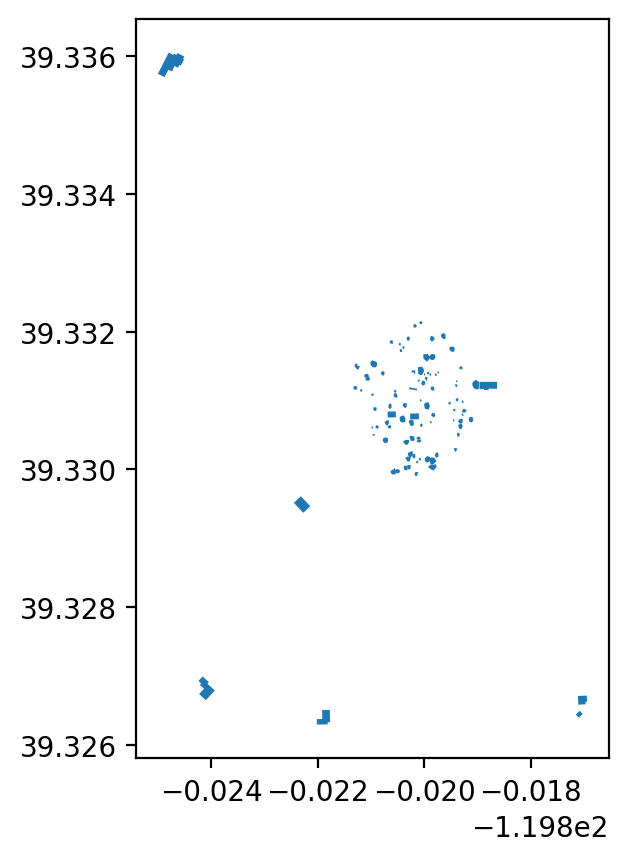

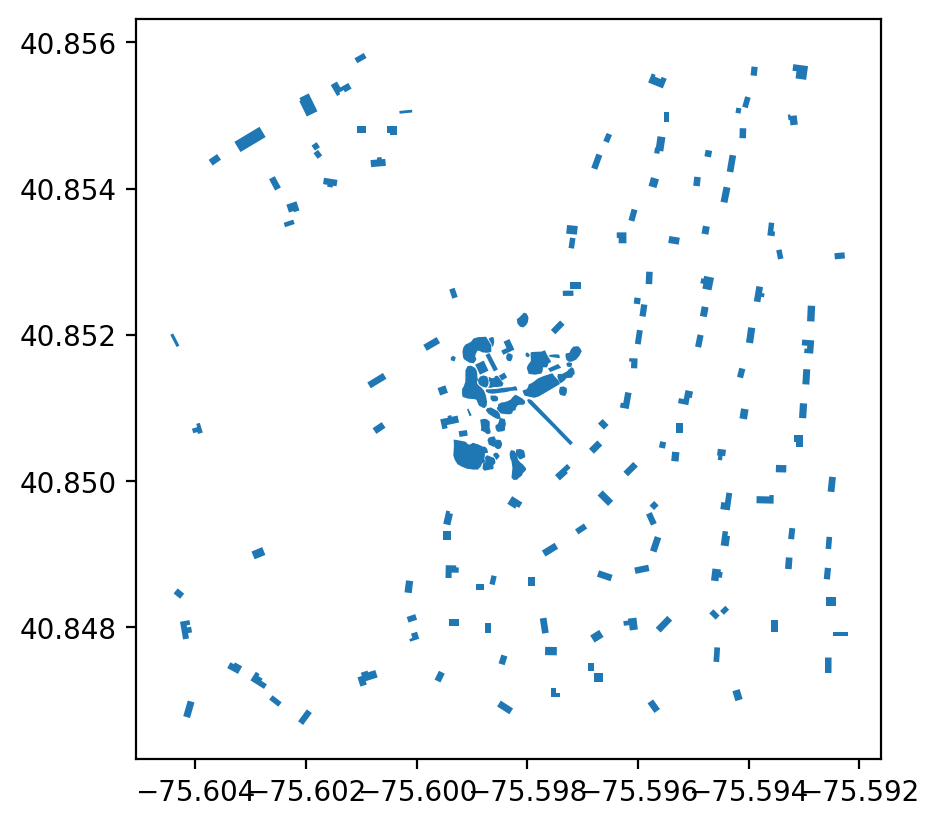

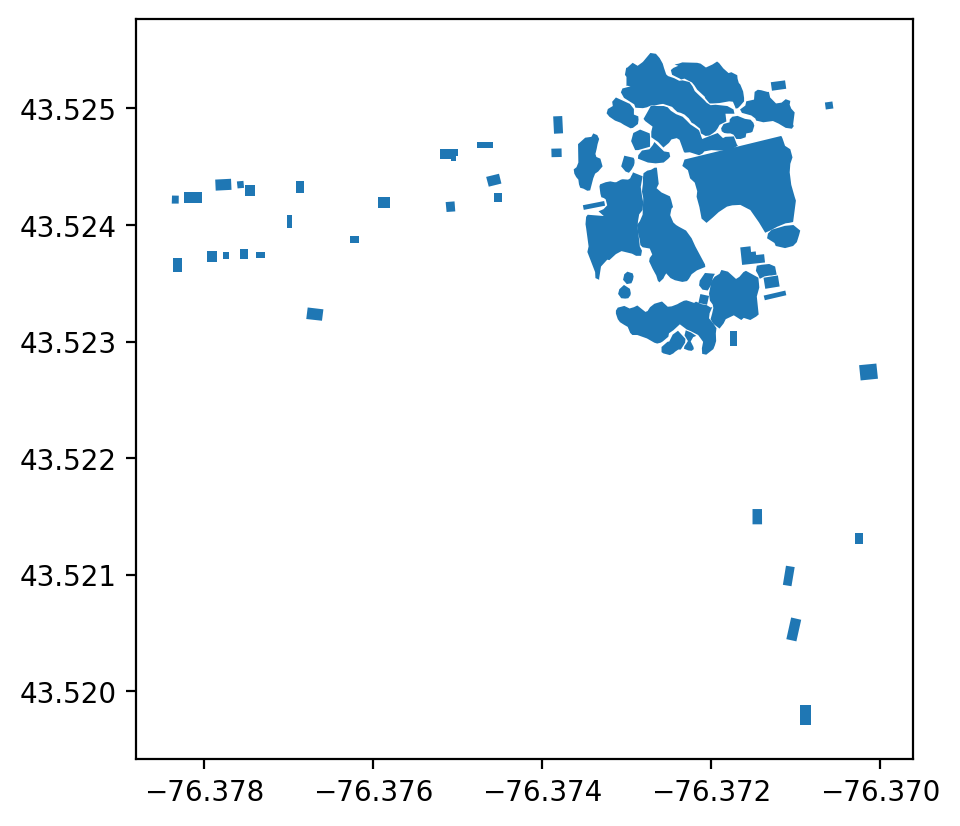

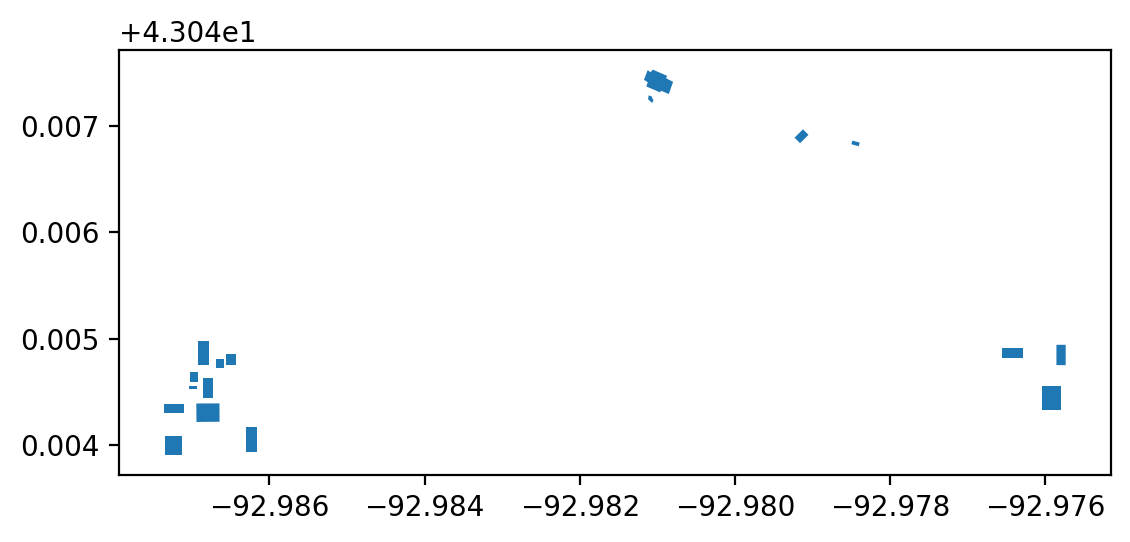

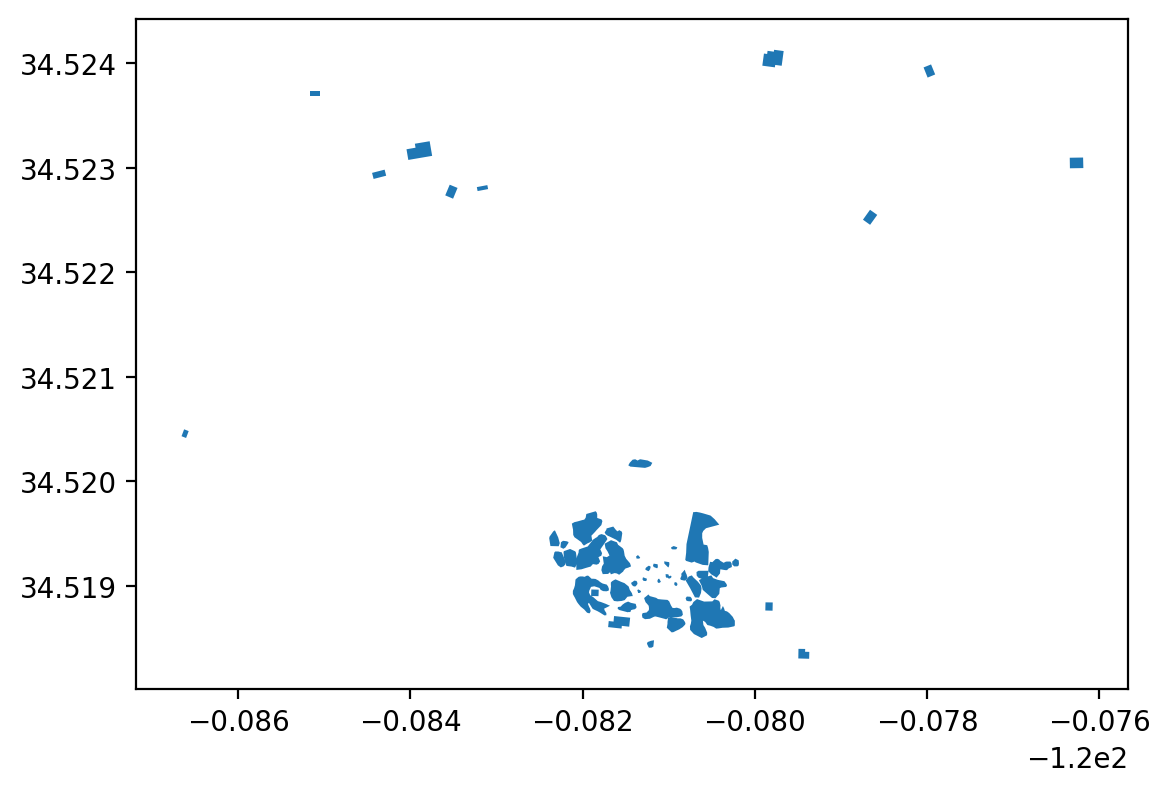

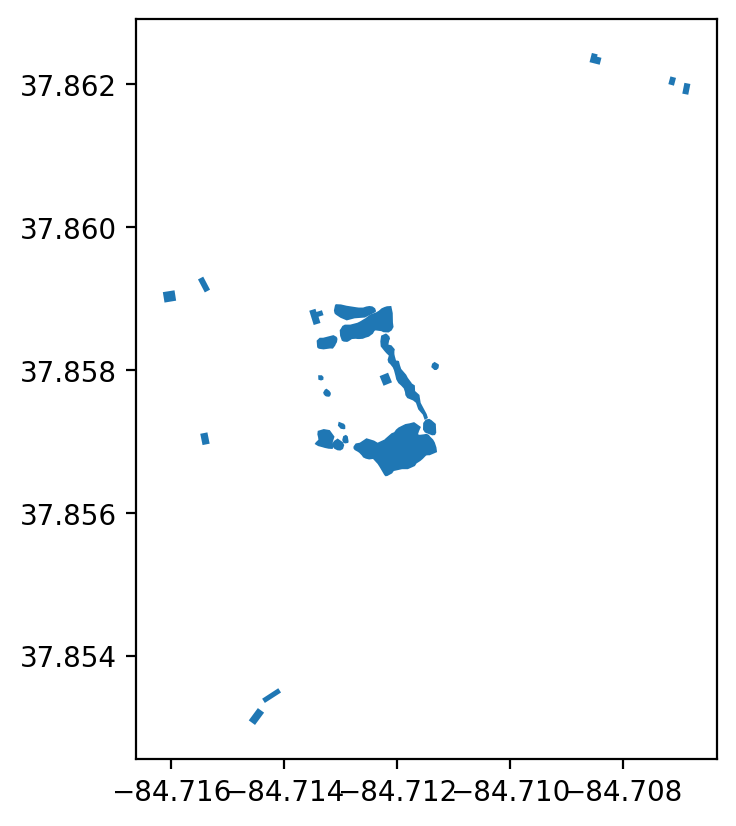

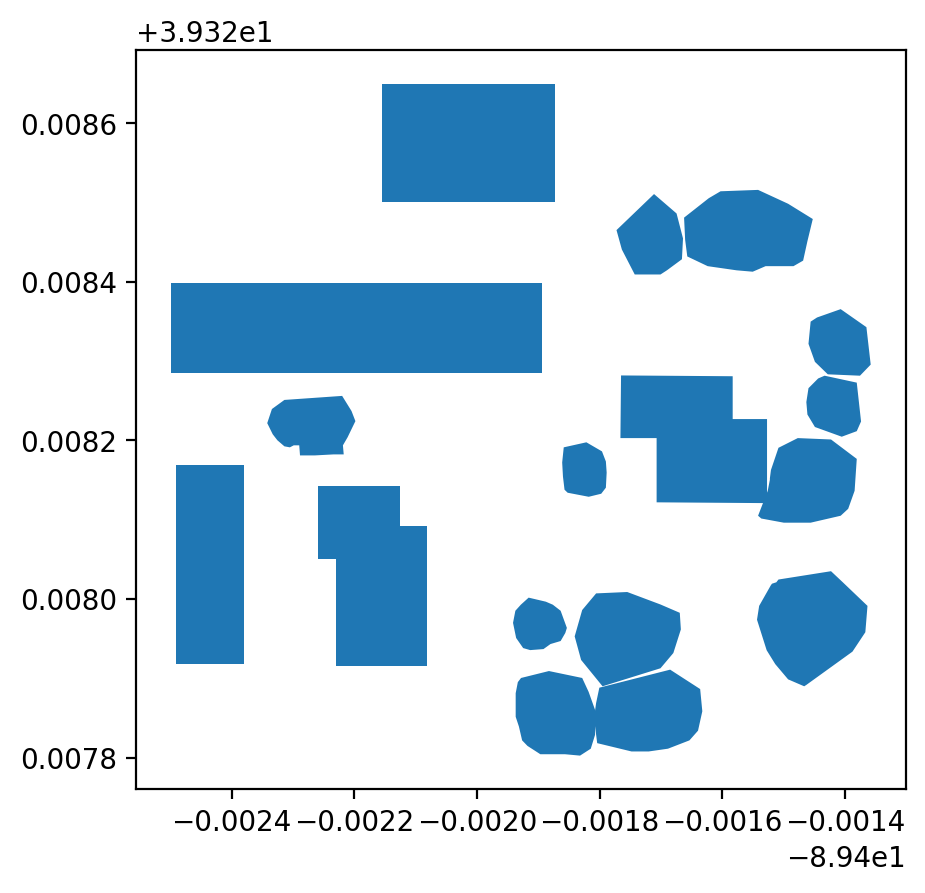

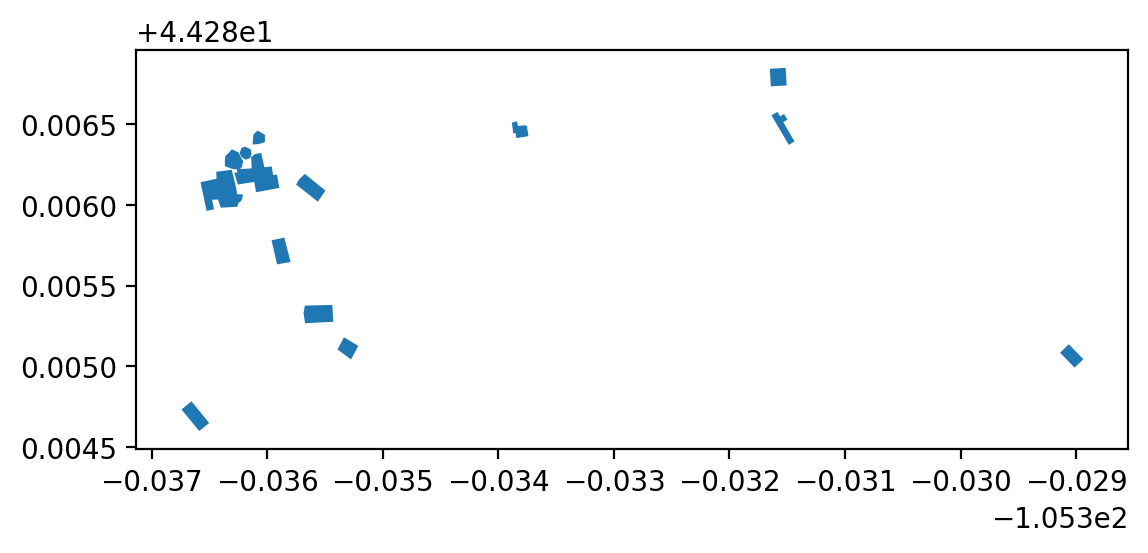

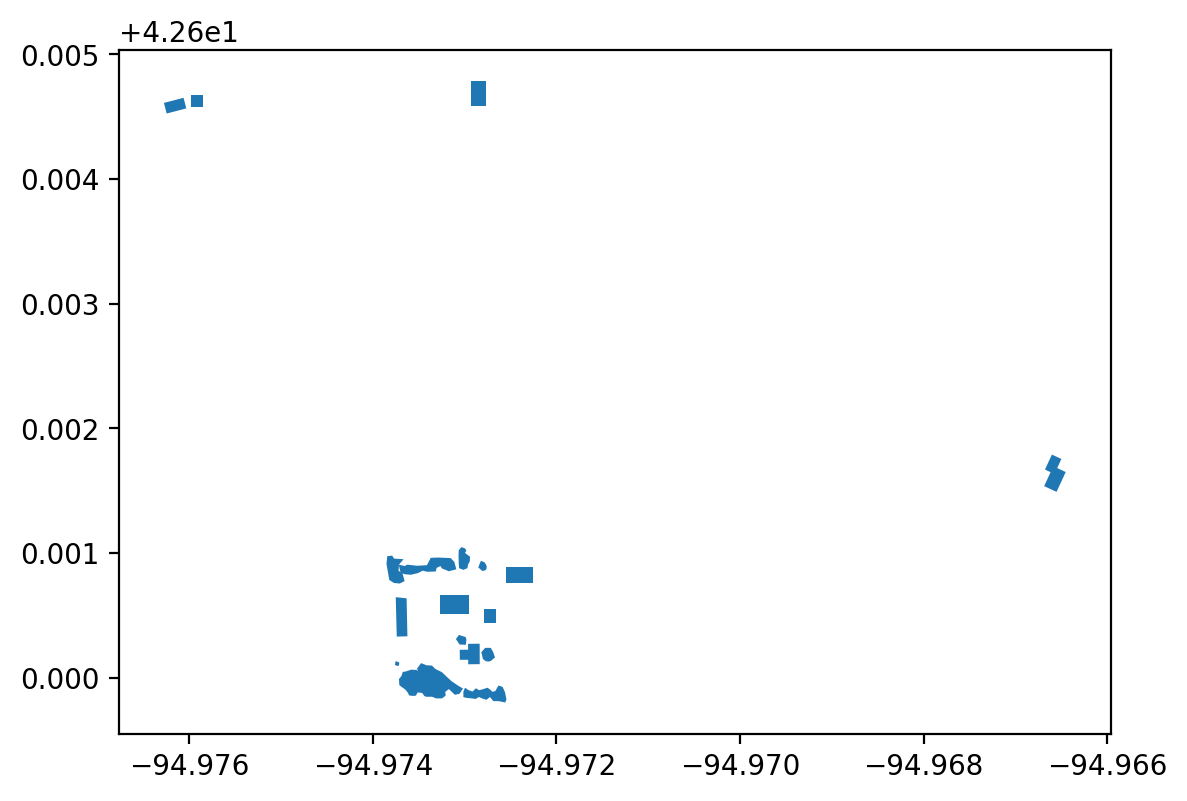

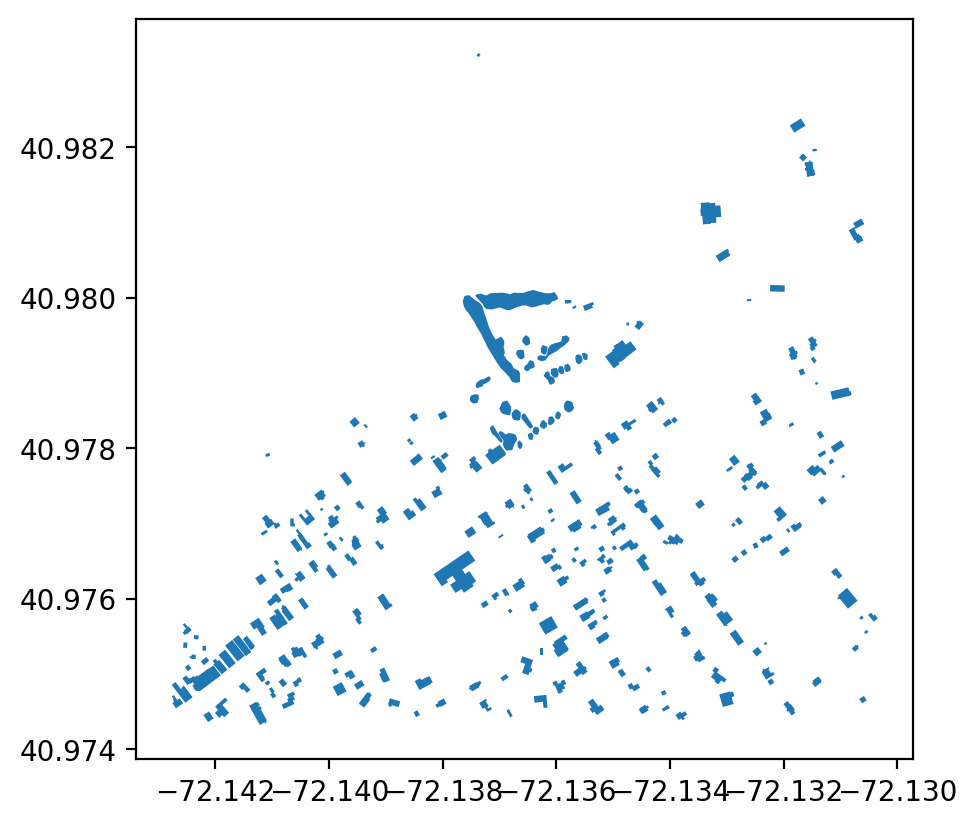

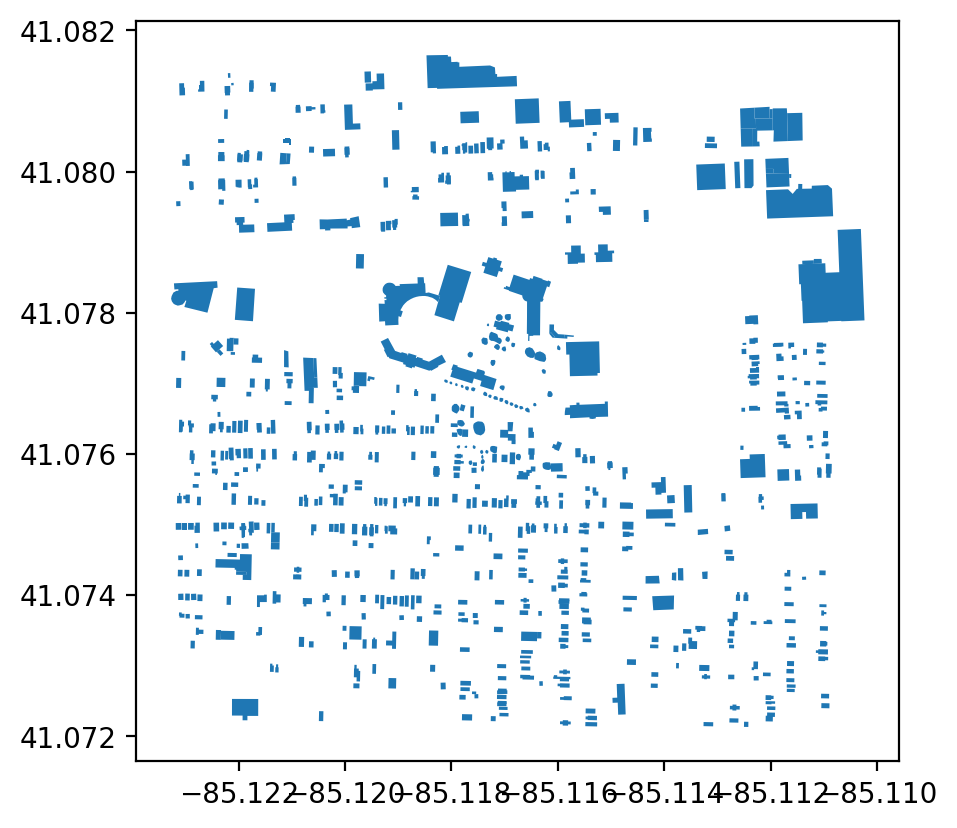

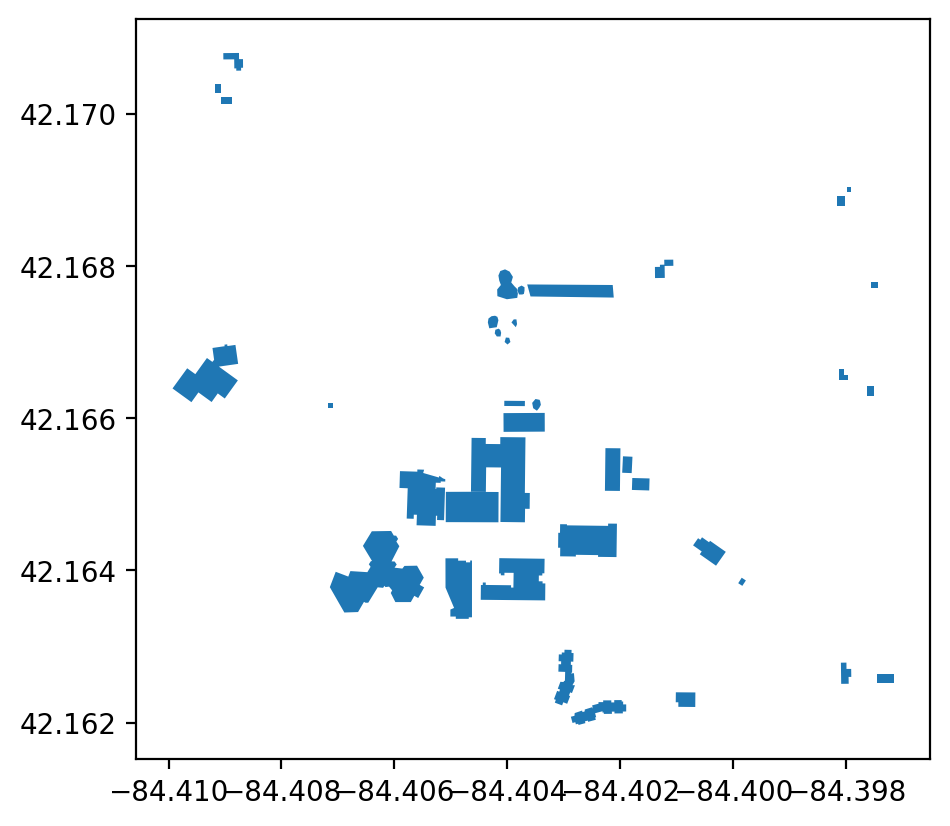

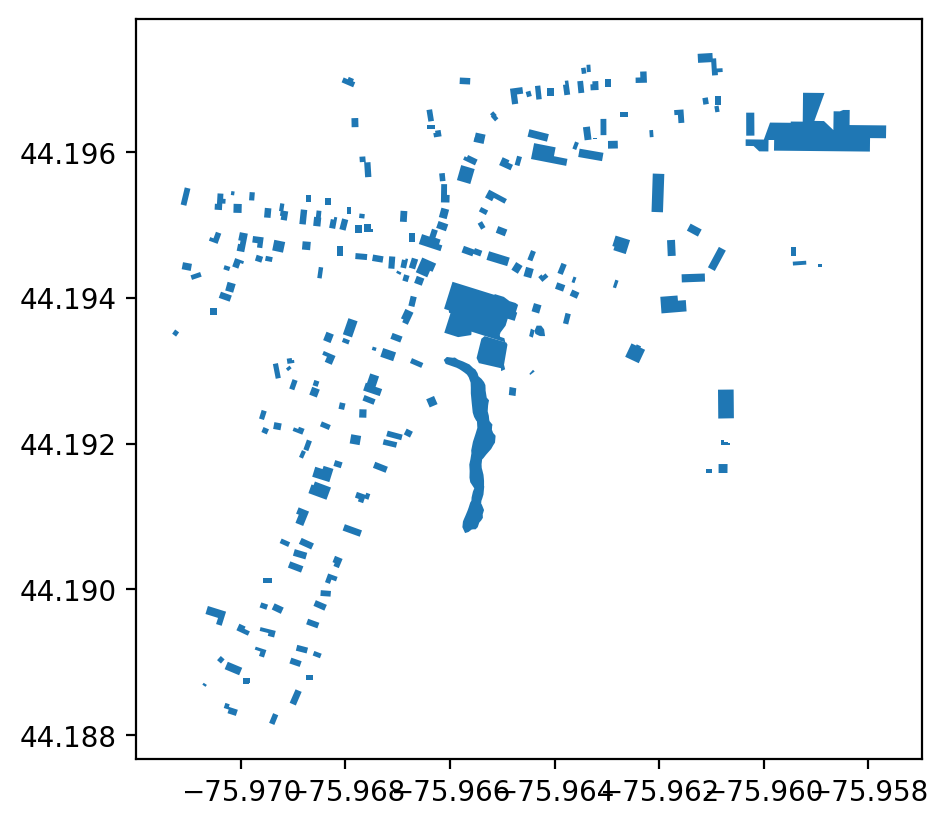

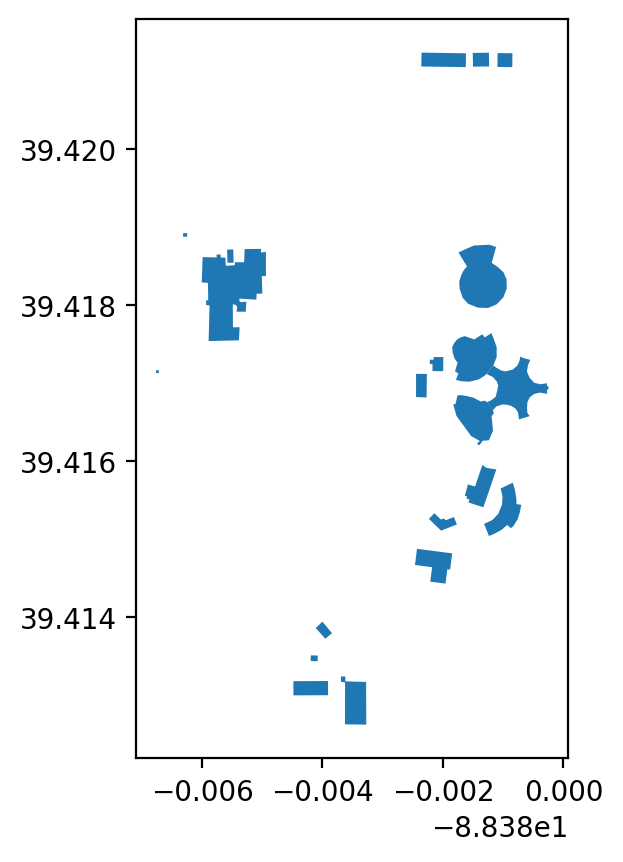

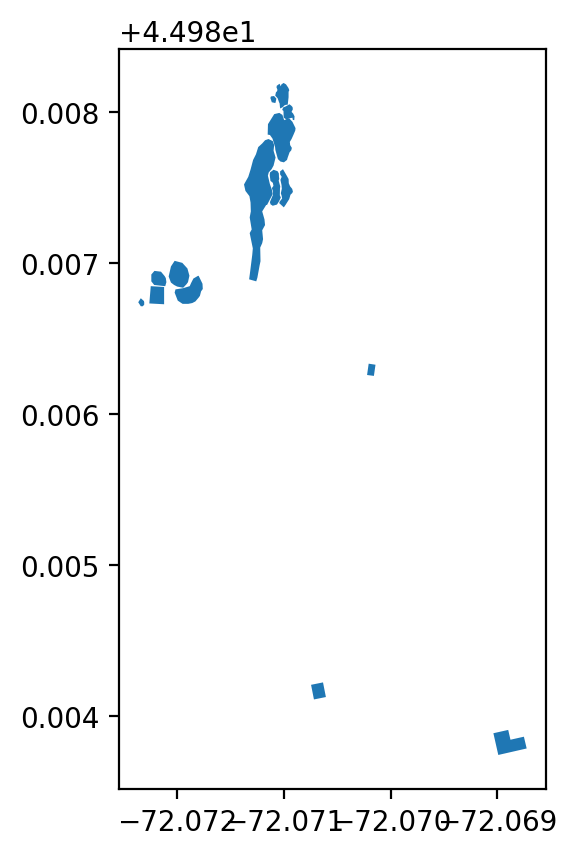

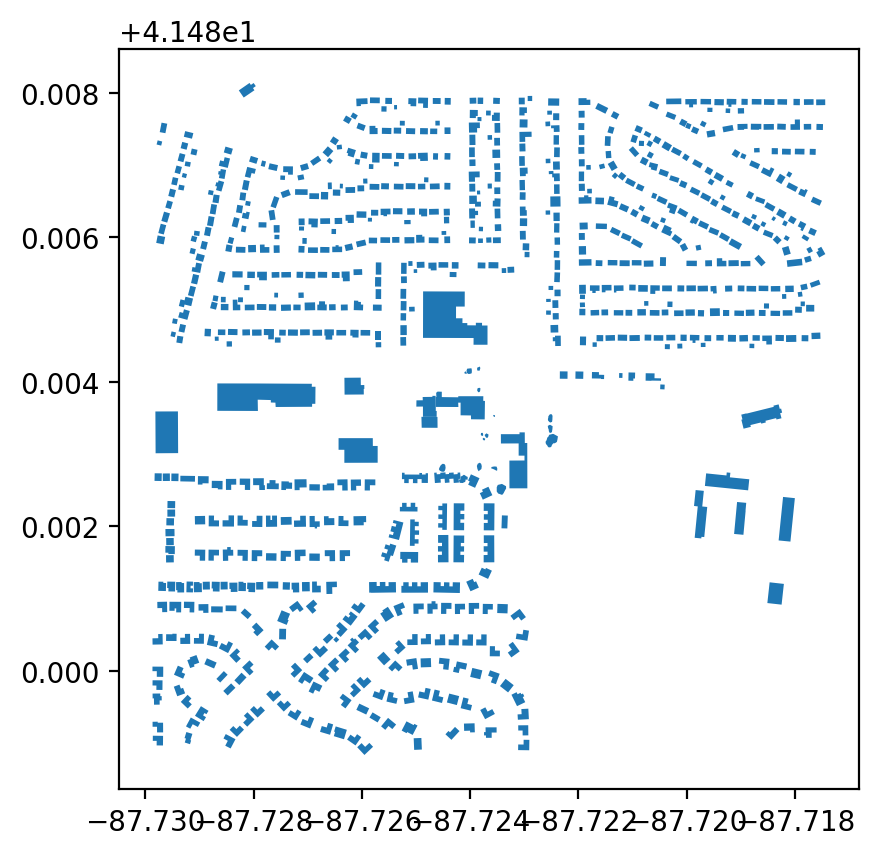

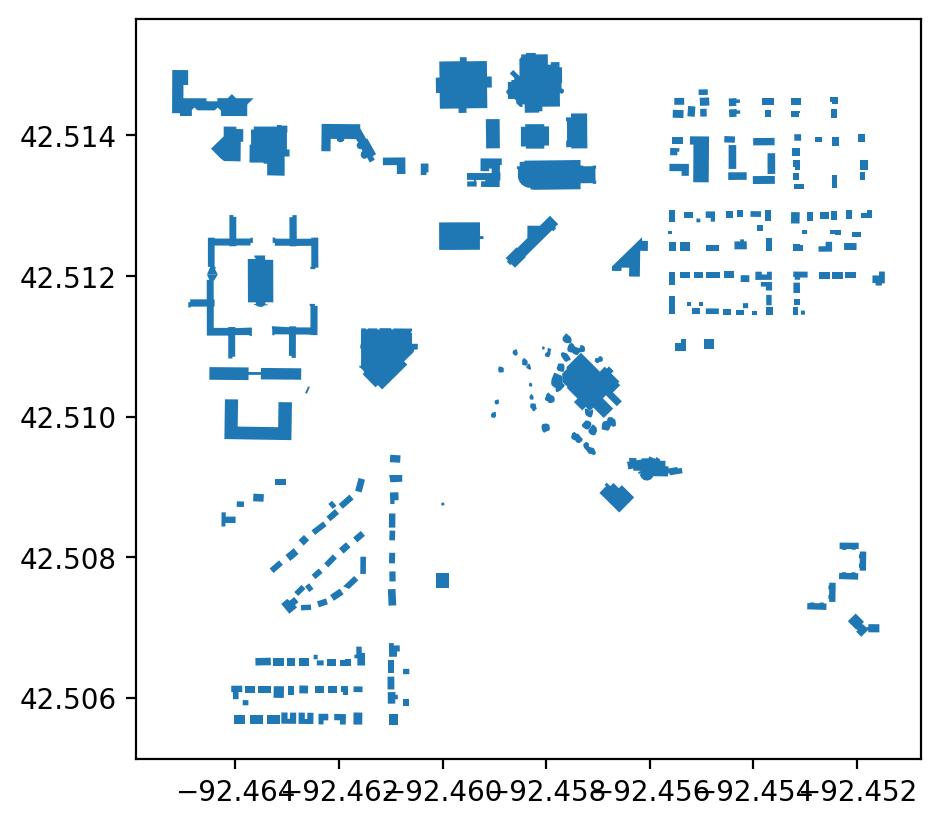

In [31]:
# Quick vis:
for tid, obstacle_df in obstacle_inputs.items():
    obstacle_df.plot()

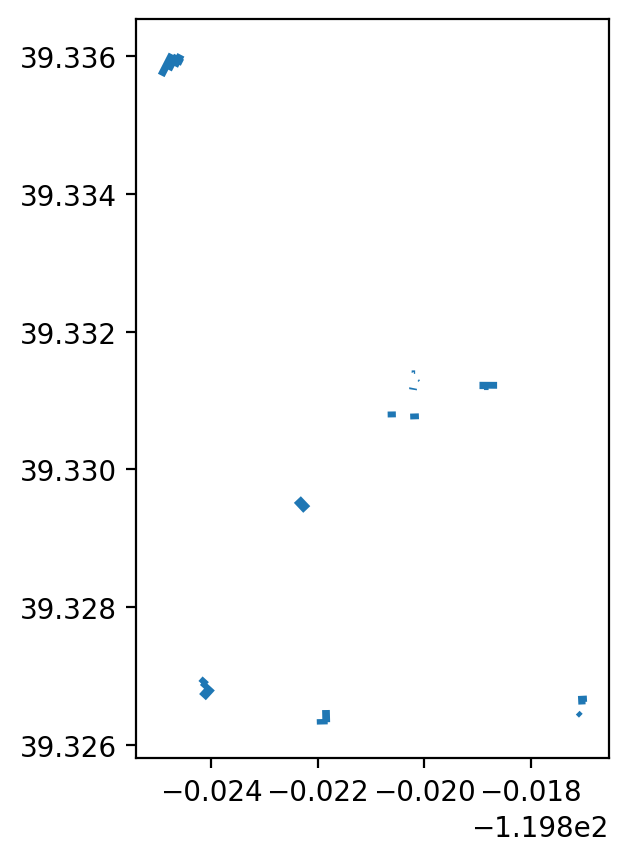

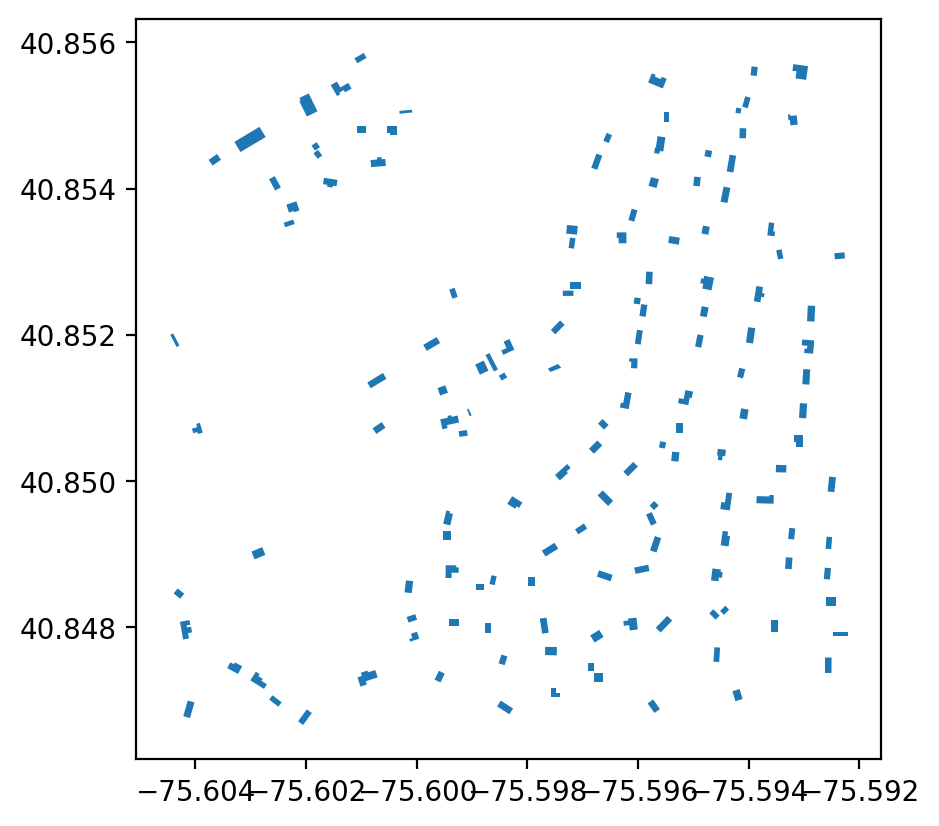

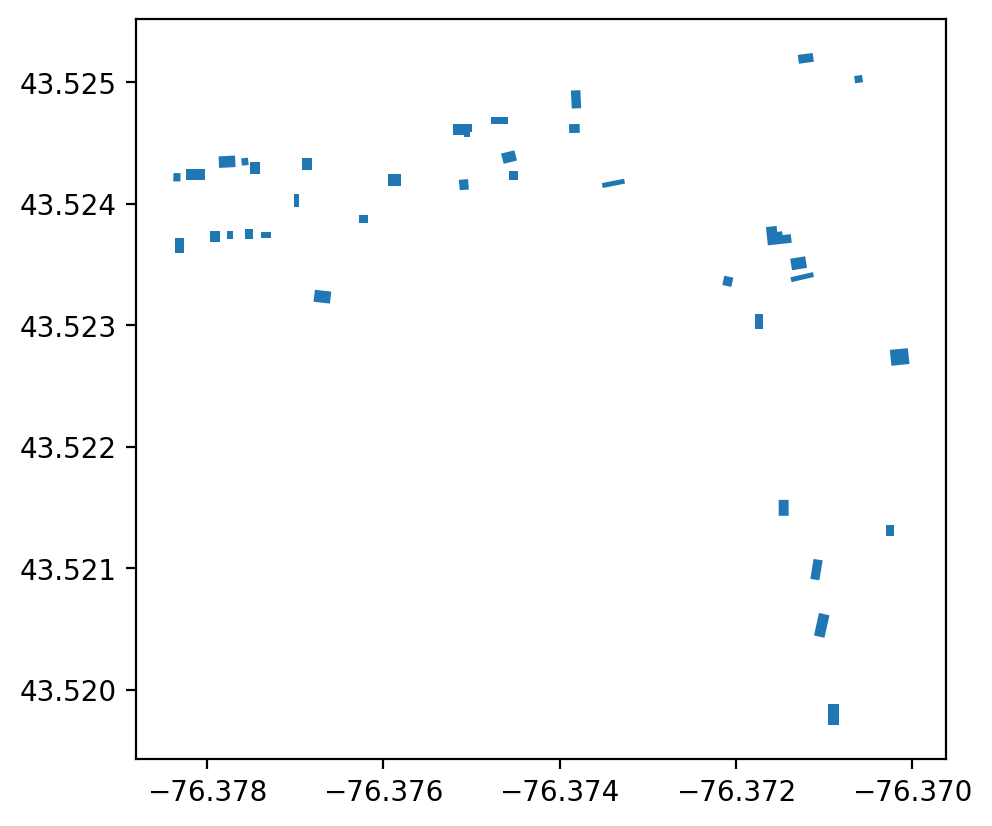

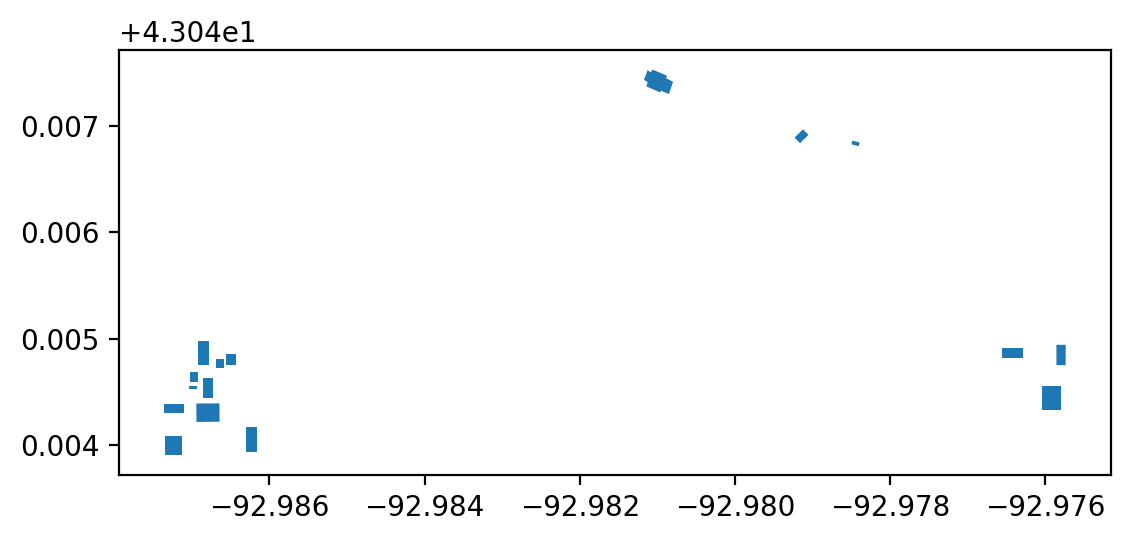

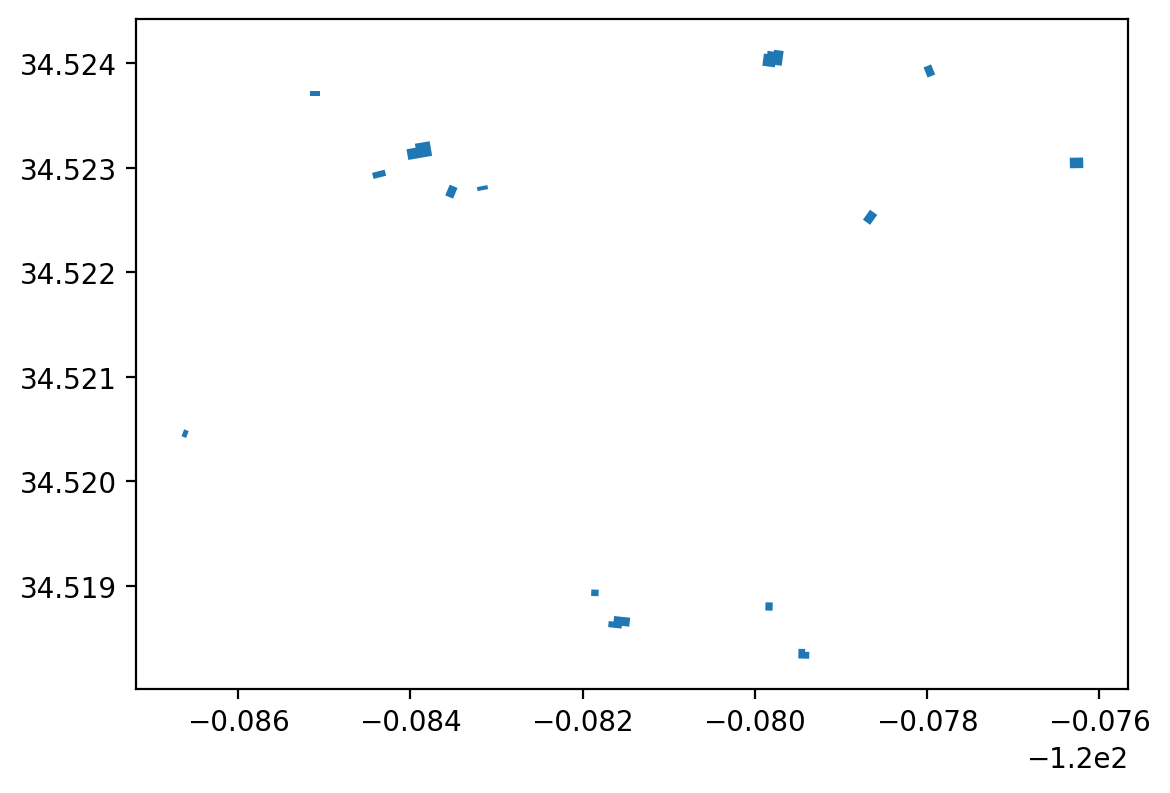

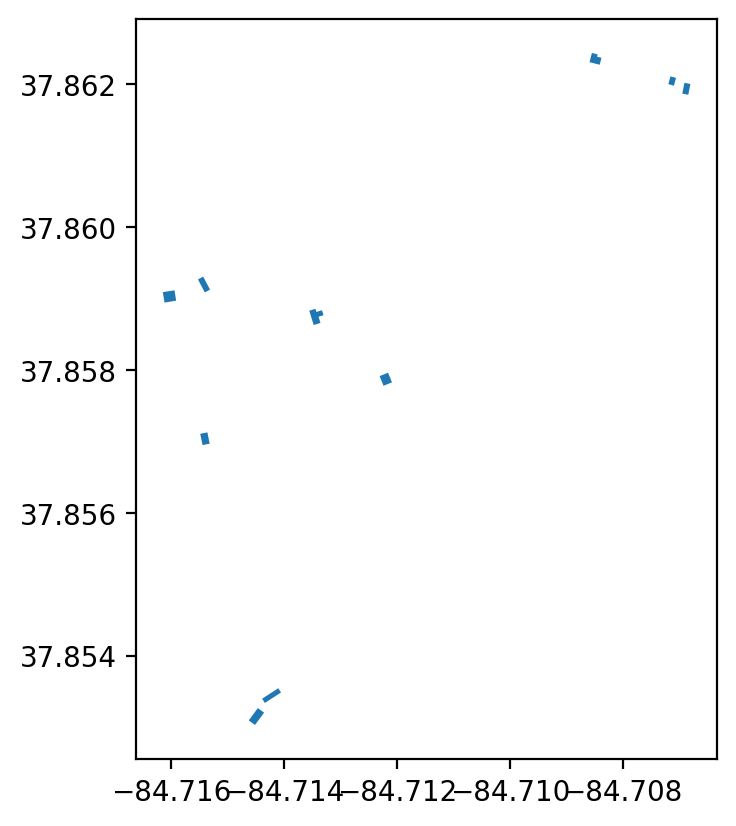

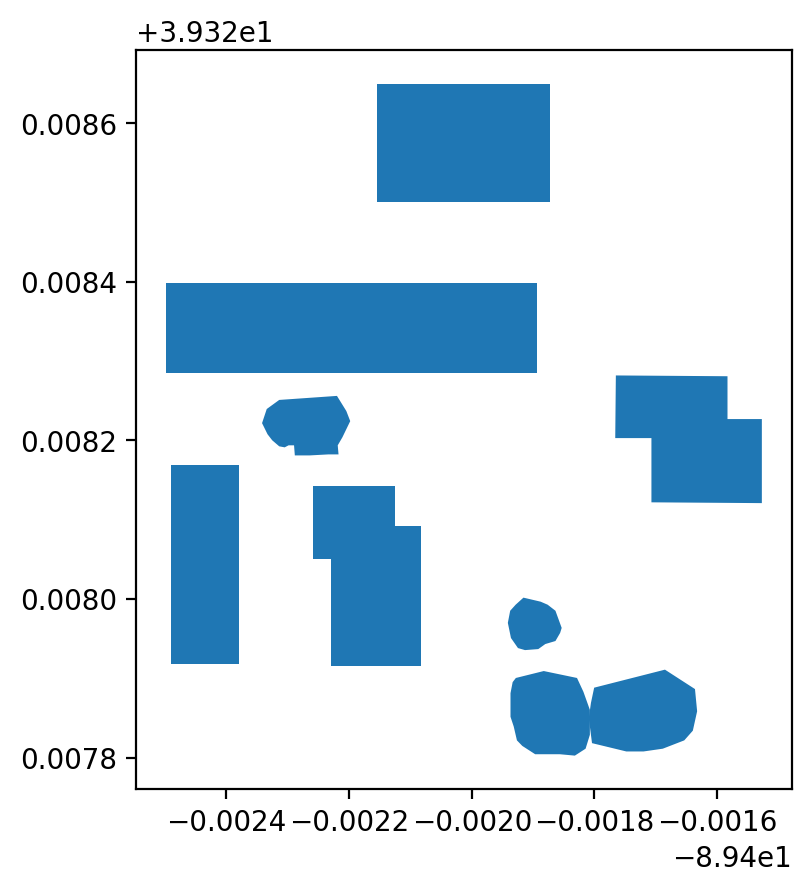

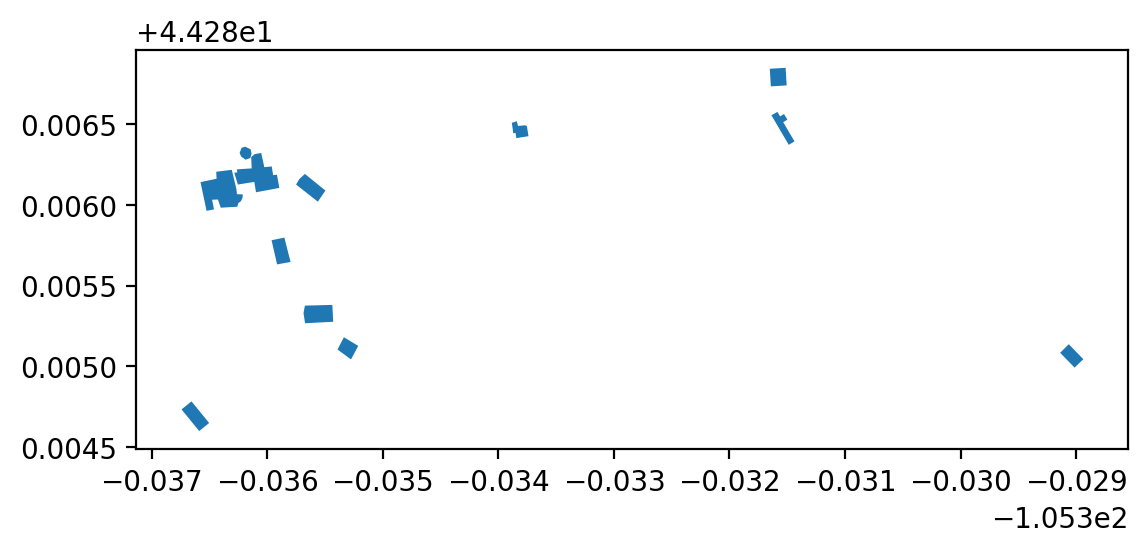

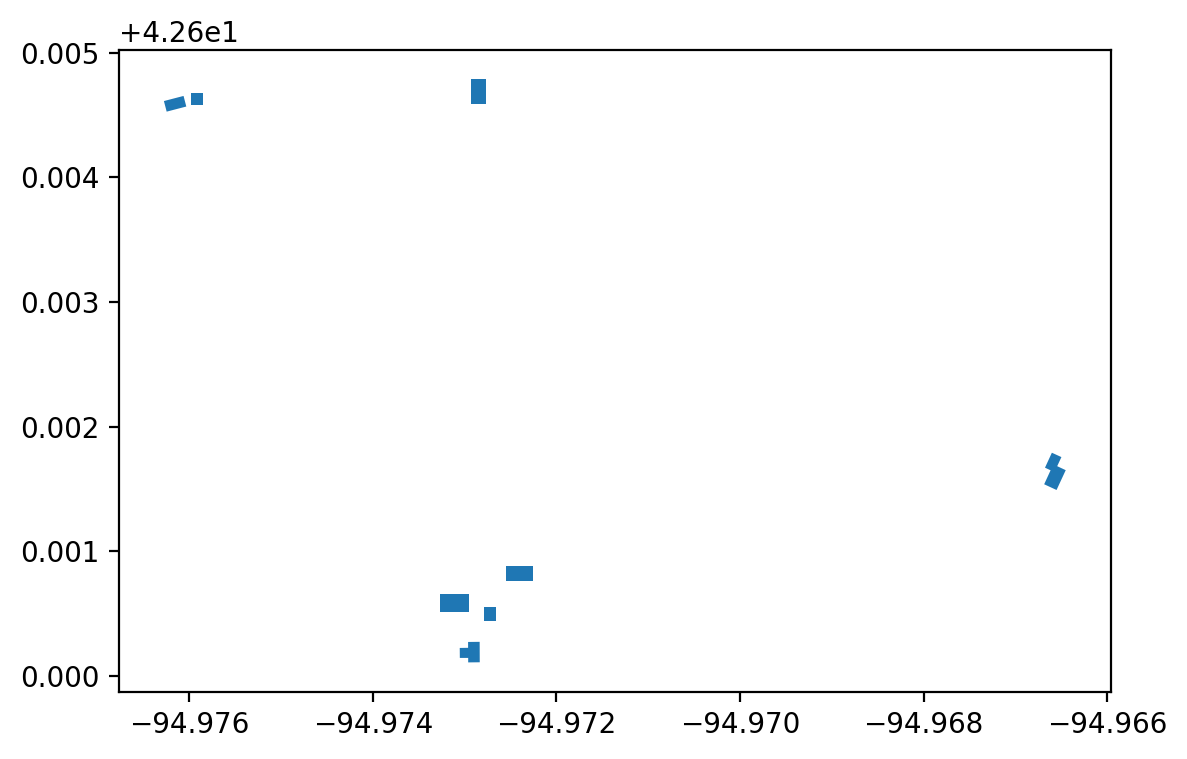

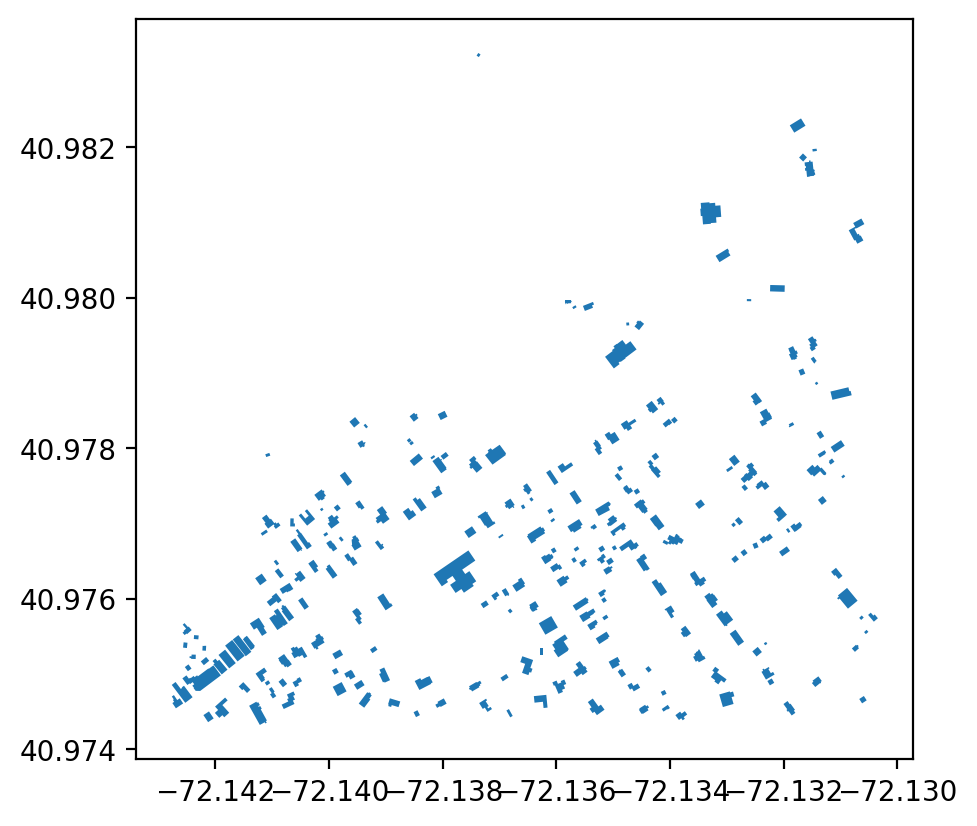

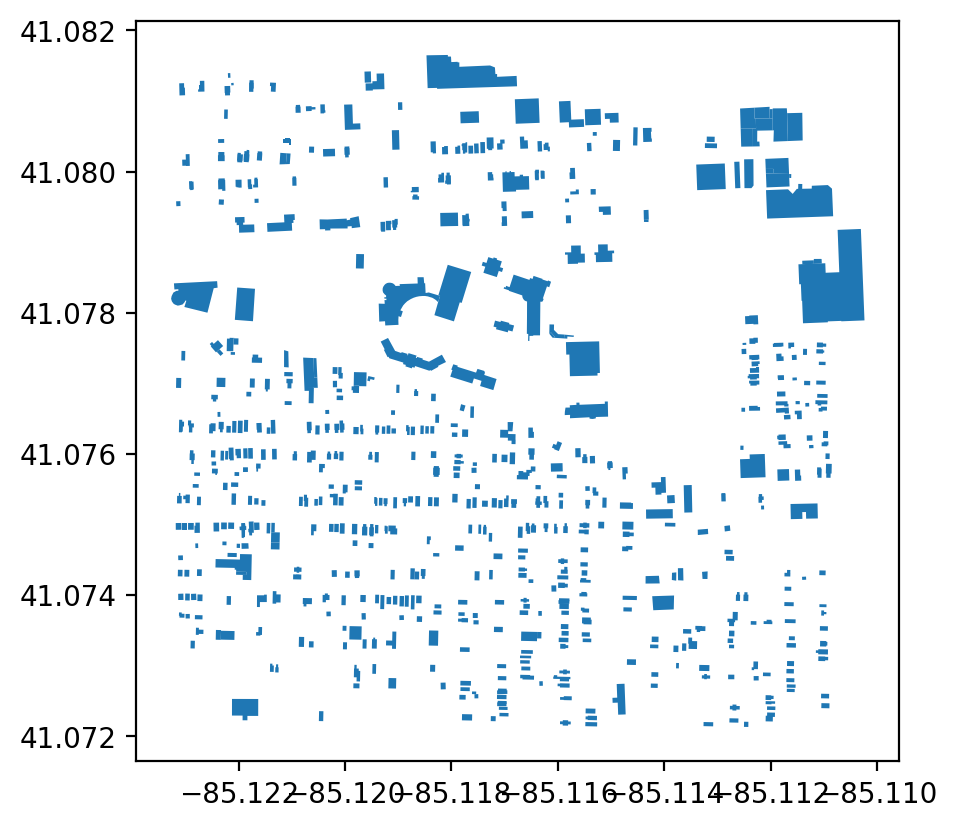

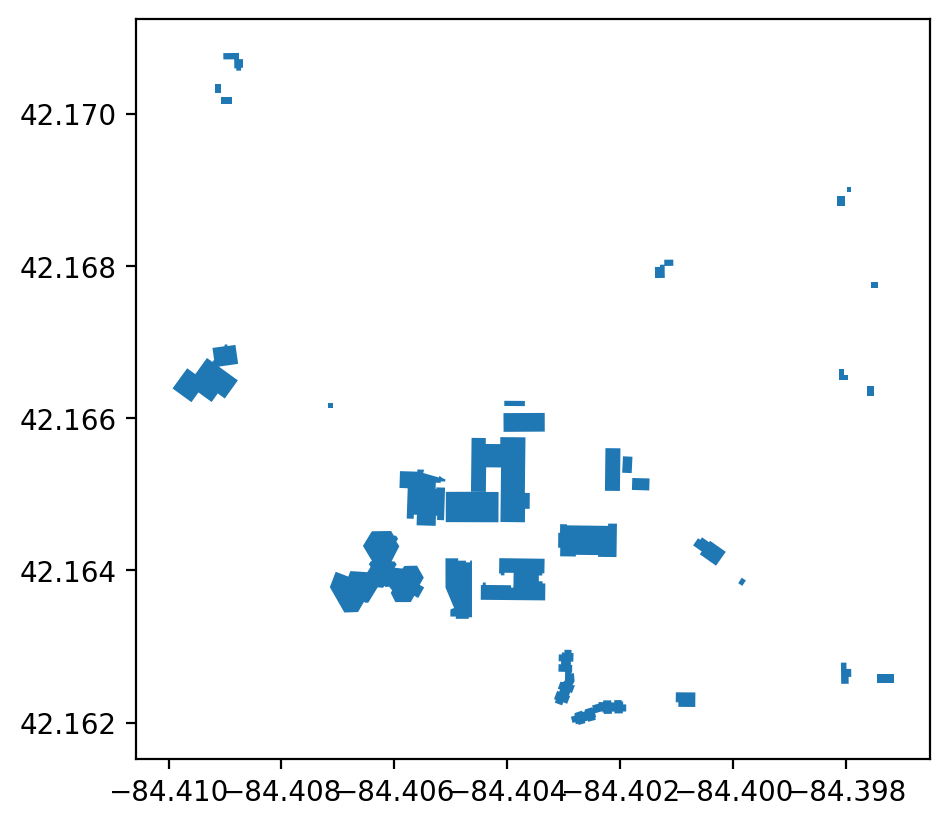

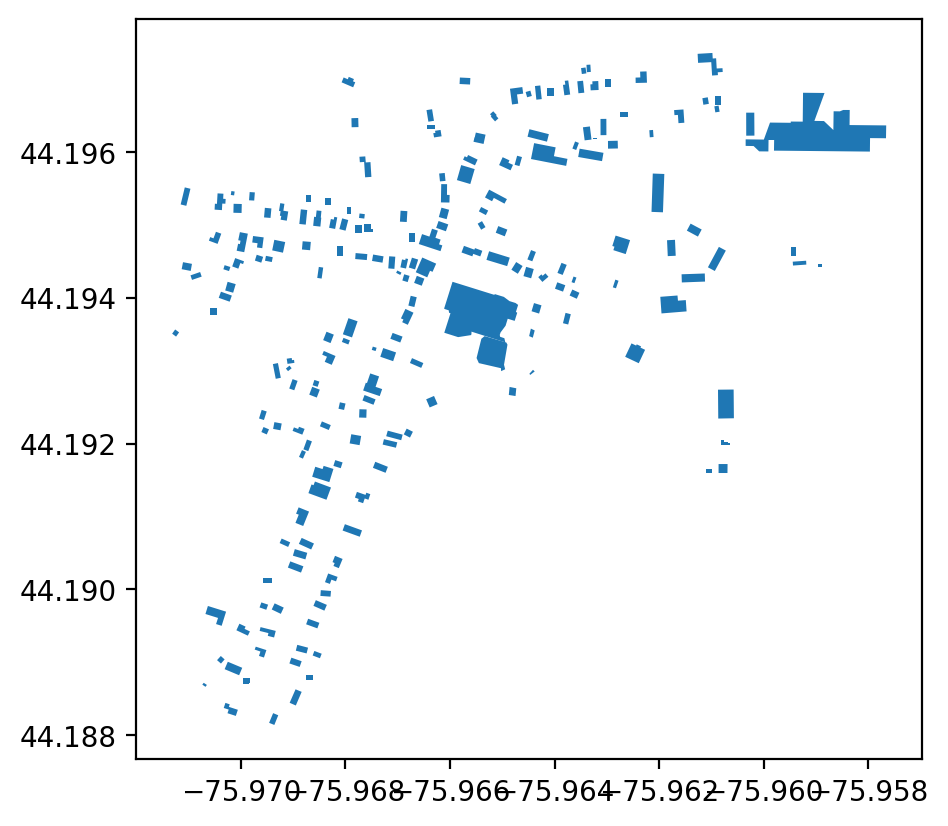

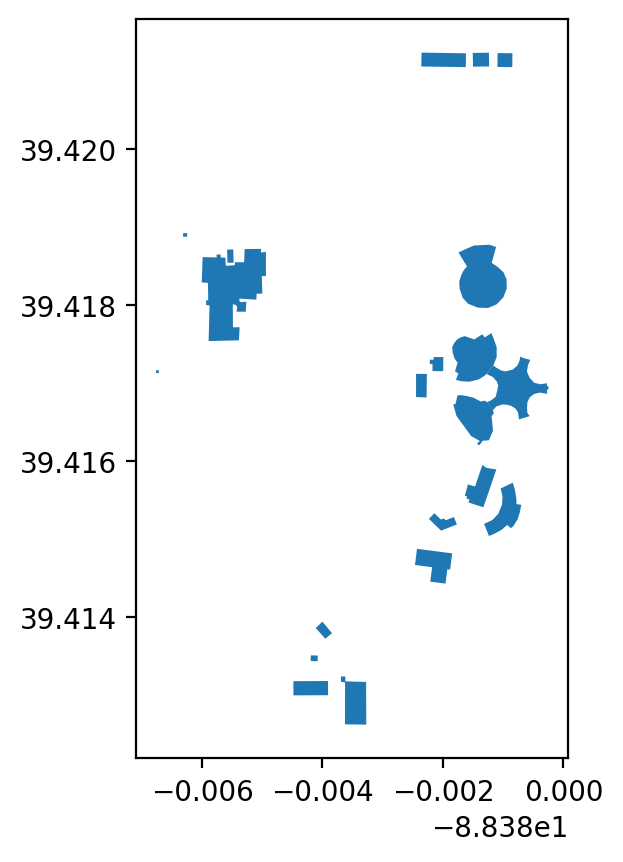

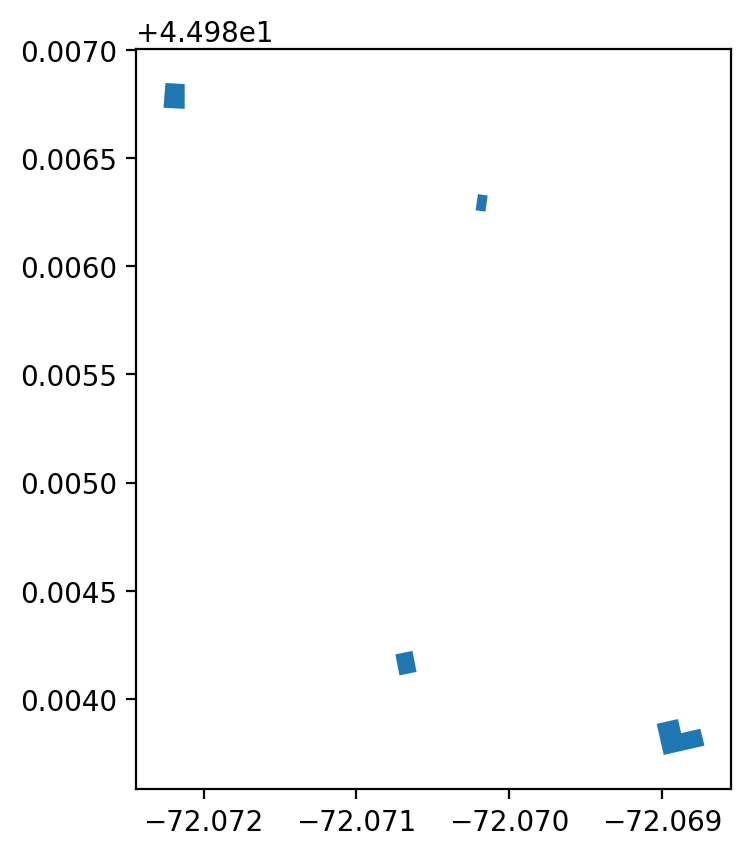

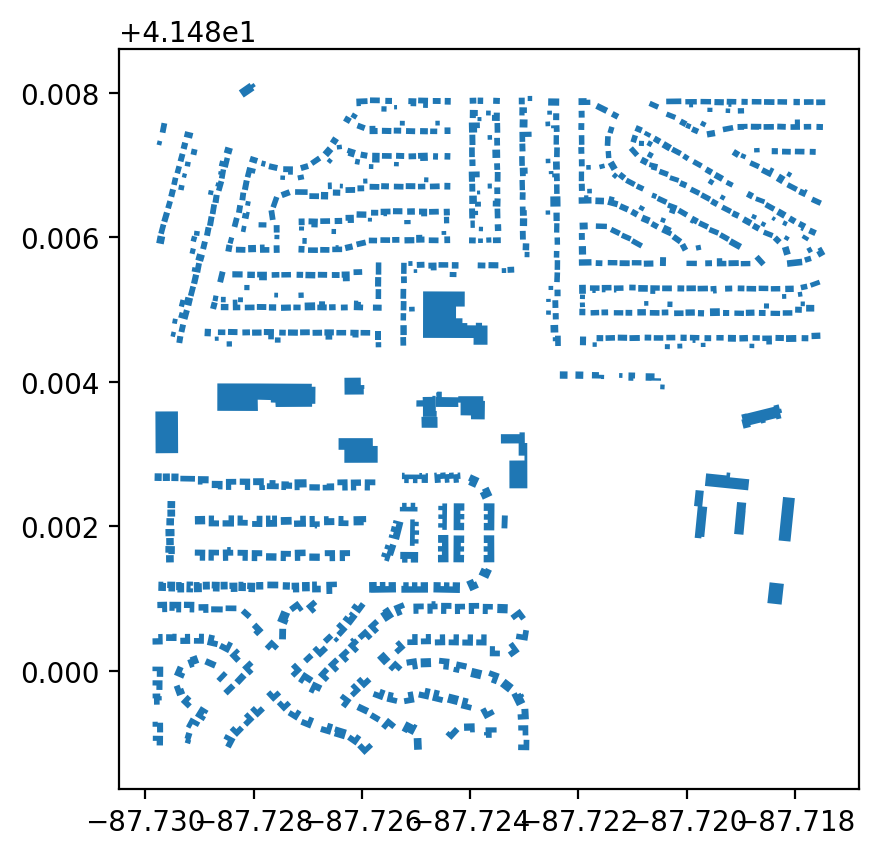

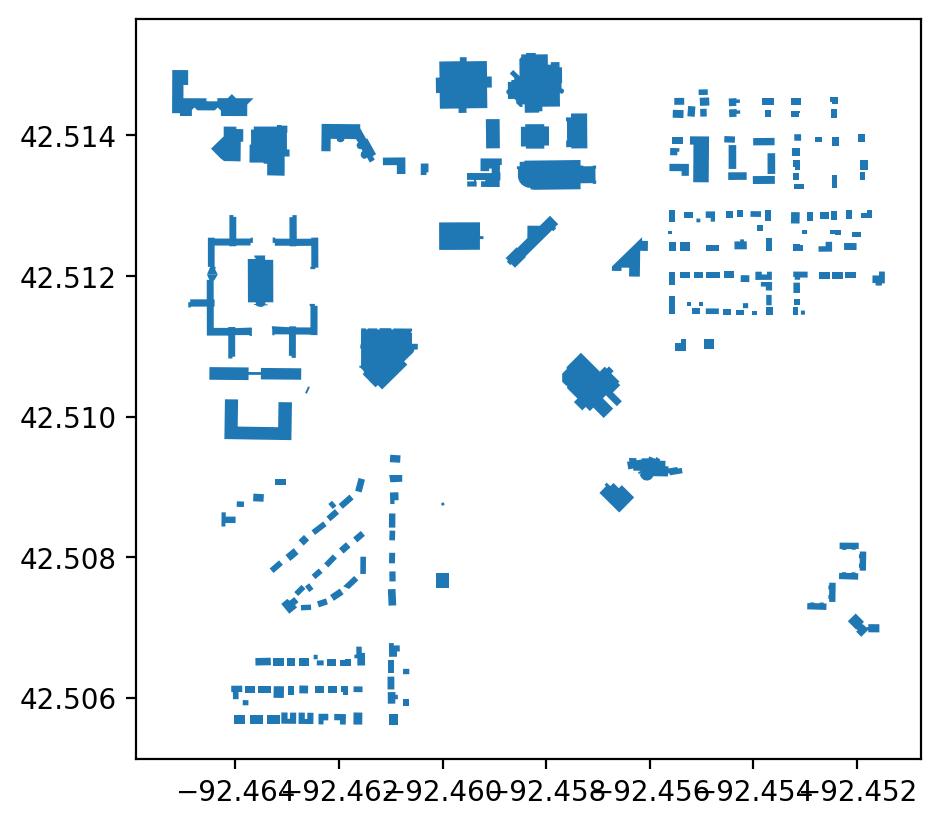

In [32]:
# Quick vis:
for tid, obstacle_df in obstacle_inputs_notrees.items():
    obstacle_df.plot()

### Calculate and Save Perera Features

In [36]:
transformer = Transformer.from_crs("epsg:4326", "epsg:3740")
buildings = fiona.open("%s/all_obstacles_epsg3740.json" % (obstacle_data_dir))
buildings_notrees = fiona.open("%s/all_obstacles_notrees_epsg3740.json" % (obstacle_data_dir))

features = {"bldgsonly": {}, "treesasbldgs": {}, "bldgsonly_100m": {}, "treesasbldgs_100m": {}}
for tid in tqdm(selected):
    row = index.lookup_by_tid(tid)
    lat = row["Latitude"]
    lon = row["Longitude"]
    lat,lon = transformer.transform(lat,lon)
    point = Point(lat,lon)
    features["treesasbldgs"][tid] = perera.calculate_perera_features(point,buildings)
    features["bldgsonly"][tid] = perera.calculate_perera_features(point,buildings_notrees)
    features["treesasbldgs_100m"][tid] = perera.calculate_perera_features(point,buildings,100)
    features["bldgsonly_100m"][tid] = perera.calculate_perera_features(point,buildings_notrees,100)
    
pickle.dump( features["treesasbldgs"], open( "%s/perera_features.p" % (obstacle_data_dir,), "wb" ) )
pickle.dump( features["treesasbldgs_100m"], open( "%s/perera_features_100m.p" % (obstacle_data_dir,), "wb" ) )
pickle.dump( features["bldgsonly"], open( "%s/perera_features_notrees.p" % (obstacle_data_dir,), "wb" ) )
pickle.dump( features["bldgsonly_100m"], open( "%s/perera_features_100m_notrees.p" % (obstacle_data_dir,), "wb" ) )

100%|███████████████████████████████████████████| 17/17 [03:21<00:00, 11.84s/it]


### Run Perera Model

In [37]:
# This flag allows overwriting previously saved files with results if they are found in the specified directory dest_dir 
overwrite = True

# Will be used in the filenames
site_type = "bergey"

# Will be used in the filenames
model_type = "perera"

# Obstacle groups
obs_groups = ["bldgsonly","treesasbldgs","bldgsonly_100m","treesasbldgs_100m"]

dest_dir = "03 Model Outputs"
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)    

In [40]:
for tid in tqdm(selected):
    
    for wind_source in wind_sources:
        
        for obsgroup in obs_groups:

            # skip those combinations that don't have data
            if len(atmospheric_inputs[wind_source][tid]) == 0:
                continue

            dest_filename = "%s/%s_%s_%s_%s_%s.csv.bz2" % (dest_dir, site_type, model_type, tid, wind_source, obsgroup)
            if (not overwrite) and (os.path.exists(dest_filename)):
                print("Found previously saved %s); overwrite flag is off. Skipping to next config." % (dest_filename))
                continue

            atmospheric_inputs[wind_source][tid]["sector"] = common.sectorize(atmospheric_inputs[wind_source][tid]["ws"])

            atmospheric_inputs[wind_source][tid]["ws-adjusted"] = \
                atmospheric_inputs[wind_source][tid][["tid","sector","ws"]].\
                apply(perera.perera,axis=1,args=(features[obsgroup],))
            atmospheric_inputs[wind_source][tid]["ws-adjusted-2"] = \
                atmospheric_inputs[wind_source][tid][["tid","sector","ws"]].\
                apply(perera.perera2,axis=1,args=(features[obsgroup],))
            atmospheric_inputs[wind_source][tid]["ws-adjusted-3"] = \
                atmospheric_inputs[wind_source][tid][["tid","sector","ws"]].\
                apply(perera.perera3,axis=1,args=(features[obsgroup],))

            atmospheric_inputs[wind_source][tid].to_csv(dest_filename, index=False)

100%|███████████████████████████████████████████| 17/17 [13:57<00:00, 49.26s/it]


In [ ]:
# Quick vis of data in produced files

for f in glob.iglob("%s/*perera*" % dest_dir):
    df = pd.read_csv(f)
    fig = plt.gcf()
    fig.set_size_inches(2.5,2.5)
    sns.scatterplot(x=df["ws"], \
                    y=df["ws-adjusted"], alpha=0.2).set(title=os.path.basename(f));
    #plt.show()